In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import chip8 as mp
import chip8_vec as vec
import chip8_vec_th as vec_th
import chip8_vec_th2 as vec_th2


plt.rcParams["figure.figsize"] = [20, 8]
sns.set_theme()

pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
game = "games/pong_1p.ch8"
modules = [
    "mp",
    "vec",
    "pytorch_cpu",
    "pytorch_gpu",
    "pytorch2_cpu",
    "pytorch2_gpu",
]
n_values = {
    module: [2**i for i in range(10)]
    if module == "mp"
    else [2**i for i in range(18)]
    for module in modules
}
max_cycles = 1_000

df = pd.DataFrame(
    columns=[
        "module",
        "n_emulators",
        "n_frames",
        "time",
        "effective_fps",
    ]
)

for module in modules:
    if module == "mp":
        main = mp.main_multiprocessing
    elif module == "vec":
        main = vec.main
    elif module == "pytorch_cpu":
        main = vec_th.main
        device = "cpu"
    elif module == "pytorch_gpu":
        main = vec_th.main
        device = "cuda"
    elif module == "pytorch2_cpu":
        main = vec_th2.main
        device = "cpu"
    elif module == "pytorch2_gpu":
        main = vec_th2.main
        device = "cuda"

    for n_emulators in tqdm(n_values[module], desc=module):
        for _ in range(5):
            if module.startswith("pytorch"):
                dt = main(
                    game,
                    n_emulators=n_emulators,
                    max_cycles=max_cycles,
                    device=device,
                )
            else:
                dt = main(game, n_emulators=n_emulators, max_cycles=max_cycles)
            new_row = pd.DataFrame(
                [
                    {
                        "module": module,
                        "n_emulators": n_emulators,
                        "n_frames": max_cycles // 8,
                        "time": dt,
                        "effective_fps": n_emulators * (max_cycles // 8) / dt,
                    }
                ]
            )
            df = (
                new_row
                if df.empty
                else pd.concat([df, new_row], ignore_index=True)
            )
df

pytorch2_gpu: 100%|██████████| 18/18 [02:32<00:00,  8.49s/it]


,module,n_emulators,n_frames,time,effective_fps
0,mp,1,125,0.014896,8.391753e+03
1,mp,1,125,0.012919,9.675651e+03
2,mp,1,125,0.009963,1.254584e+04
3,mp,1,125,0.009896,1.263121e+04
4,mp,1,125,0.008927,1.400224e+04
...,...,...,...,...,...
495,pytorch2_gpu,131072,125,4.563033,3.590594e+06
496,pytorch2_gpu,131072,125,4.438929,3.690981e+06
497,pytorch2_gpu,131072,125,4.710903,3.477889e+06
498,pytorch2_gpu,131072,125,4.877975,3.358770e+06


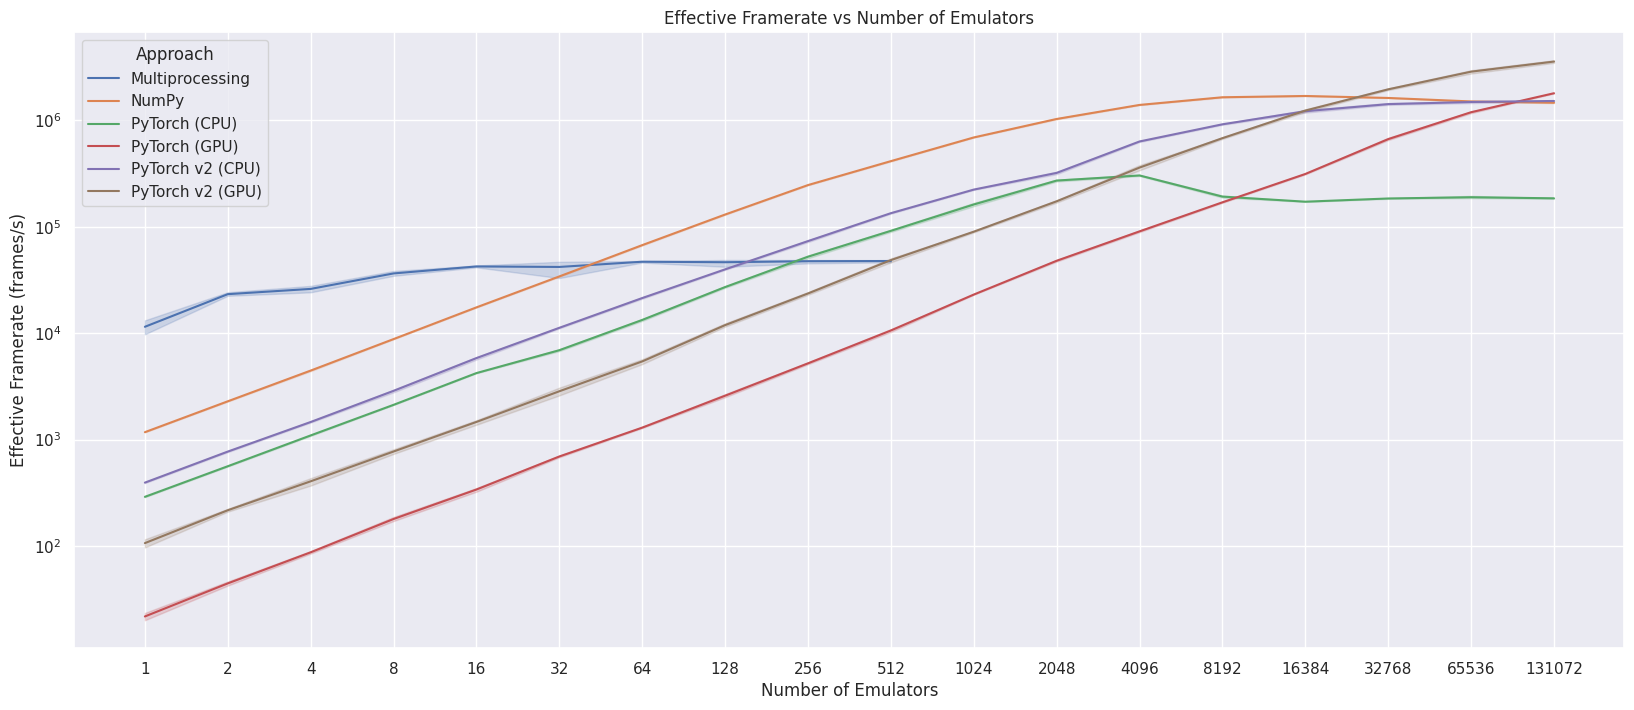

In [5]:
df["approach"] = df["module"].replace(
    {
        "mp": "Multiprocessing",
        "vec": "NumPy",
        "pytorch_cpu": "PyTorch (CPU)",
        "pytorch_gpu": "PyTorch (GPU)",
        "pytorch2_cpu": "PyTorch v2 (CPU)",
        "pytorch2_gpu": "PyTorch v2 (GPU)",
    }
)

ax = sns.lineplot(data=df, x="n_emulators", y="effective_fps", hue="approach")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(n_values["vec"])
ax.set_xticklabels(n_values["vec"])
ax.legend(title="Approach", loc="upper left")

plt.xlabel("Number of Emulators")
plt.ylabel("Effective Framerate (frames/s)")
plt.title("Effective Framerate vs Number of Emulators")
plt.show()